<a href="https://colab.research.google.com/github/thymerishere/deep-image-prior-reproduced/blob/master/deep_image_prior_reproduced_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Deep Image Prior
In this notebook we analyse different characteristics of several applications as described in the [original Deep Image Prior paper](https://arxiv.org/abs/1711.10925) published by Ulyanov et al.

We looked at four different aspects:
1. reproduce inpainting and analyse consequences of different settings of hyperparameters
2. run the restoration/inpainting application code for new images with different settings of the hyperparameters to check which gives the best results
3. test how the setup of skip connections in the network influence the performance of restoration logic on selected images
4. reproduce table 1/figure 7 from the [original paper](https://arxiv.org/abs/1711.10925), also looking at how the reported value (PSNR) evolves over time

Each of these tasks is contained in its own section below with separate description and code.

---

## How does Deep Image Prior work?
With deep convolutional neural nets (ConvNets) being the state of the art in reverse image reconstruction, Ulyanov et al. [argue](https://arxiv.org/abs/1711.10925) that the assumption that the excellent performance is obtained due to the ability of ConvNets to learn realistic image priors from data, is flawed. They aim do demonstrate that image reconstruction can be done using only the information of the single degraded input image.
This is done by interpreting the generator neural network as a parameterisation $x=f_\theta(z)$ of an image $x \in \mathbb{R}^{3\times H \times W}$ with $z\in \mathbb{R}^{C' \times H' \times W'}$ a randomly initialised code vector. This then gives the following optimisation: $$\theta^* = argmin_\theta E(f_\theta(z); x_0), \quad x^*=f_{\theta^*}(z)$$
where, using gradient descent and starting from a random initialisation of the parameters, the aim is to achieve the optimal parameters $\theta^*$ to obtain the optimal mapping of noise to output image $x^*=f_{\theta^*}(z)$. The data term $E(x, x_0)$ is dependent on the task performed where Ulyanov et al discussed denoising, generic reconstruction (JPEG restoration), super-resolution, inpainting, restoration, natural pre-image and flash-no flash reconstruction.

The statement from Ulyanov et al. is that along the path from random noise to the corrupted image the neural net will prefer repairing/following the natural structures in an image than the noisy structures. This is implemented in how the loss is computed. First the same corruption is applied to the output image before computing the loss against the target corrupted image. This means that the loss function does not explicitly drive the repair of the noisy structures. This is left over to the implicit behavior of the neural network. 

---

## Experimental Setup
The authors performed all tasks on images from the [GCF-BM3D dataset](http://www.cs.tut.fi/~foi/GCF-BM3D/) using varying hyperparameters which are explained in more depth in the [original paper's supplementary](https://dmitryulyanov.github.io/deep_image_prior). The code Ulyanov et al. have written to obtain their results in the original paper is [fully provided](https://github.com/DmitryUlyanov/deep-image-prior) and we use their code to obtain similar results on three of the tasks of the paper. We will also use a custom made set of images to view the performance on a different dataset. Next we will discuss how to setup the experiment.

---

## Running this Experiment on Google Colab
In order to run this experiment, a few steps need to be taken in order to load the files needed. First, get the [original Deep Image Prior project from github](https://dmitryulyanov.github.io/deep_image_prior) and put it inside the root folder of your Google Drive home folder. Then, download the provided extra dataset from our github repository and put it inside `deep-image-prior-master/data`. This following code snippet will then mount your Google Drive and navigate to the project folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/deep-image-prior-master

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/deep-image-prior-master


---

## Inpainting
Image inpainting is specified by Ulyanov et al. as reconstructing missing data given an image $x_0$ with missing pixels denoted by a binary mask $m \in \{0,1\}^{H \times W}$. This gives a data term of $$E(x;x_0)=||(x-x_0) \odot m||^2$$ with $\odot$ being Hadamard's product. This data term is then used in the optimisation objective discussed previously. The task is specified in the code supplied by Ulyanov et al. with a number of default hyper-parameters. We will discuss the reproduction process wherein we reproduce Figure 7 and 8 from the original paper and because no reasoning has been given on the chosen values for the hyper-parameters we will try to discuss some of them and their influence on the results.

### Reproducing
Using the following [code](https://github.com/DmitryUlyanov/deep-image-prior) from the original paper we can perform the inpainting tasks. Uncommenting either the location to the vase image and its mask or the Kate image and its mask replicates respectively the results from Figure 6 and 7 in the original paper.

In [0]:
# Imports

from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [0]:
############### Select the correct image.

# Uncomment for vase.
img_path  = 'data/inpainting/vase.png'
mask_path = 'data/inpainting/vase_mask.png'

# Uncomment for Kate.
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

##############

# Creating the image and image mask.
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

# Visualising the task.
img_mask_var = np_to_torch(img_mask_np).type(dtype)
plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [0]:
# Setting hyperparameters. Automatically selects the hyperparameters
# for the corresponding task.
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path):
    # Hyperparameters are the same as super resolution.
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Setting loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

In [0]:
# Main loop.
i = 0
def closure():
    
    global i

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        print("Iteration ", i)
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
i = 0

# Printing the result to the screen.

out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

We can see that indeed we obtain a very similar results to the those presented in the original paper.

### Hyperparameter Analysis
The [original paper](https://arxiv.org/abs/1711.10925) specifies, besides the network structure which will be discussed in the section on restoration, six hyperparameters:

| Hyperparameter | Name in the code | Default value |
| -------------- | ---------------- | ------------- |
| Amount of input channels | `input_depth` | 2 for vase, 32 for Kate |
| Network input type | `INPUT` | Mesh for vase, noise for Kate|
| Standard deviation of the input noise $\sigma_p$ | `reg_noise_std`| $\frac{1}{20}$ |
| Number of iterations | `num_iter` | 5000 |
| Learning rate | `LR` | 0.1 |

As the [original paper](https://arxiv.org/abs/1711.10925) states that its main aim is not to maximise PSNR, we will analyse the effect of the hyperparameters on the visual quality of the result on images from a dataset we created for this analysis. The following method allows us to run their code with different hyperparameters, images and masks.




In [0]:
# Defines inpainting method with default values.
def inpainting(img_path, mask_path, INPUT='noise', input_depth=2, LR=0.01,
               num_iter=5000, reg_noise_std=0.05):

    # Creating the image and image mask.
    img_pil, img_np = get_image(img_path, imsize)
    img_mask_pil, img_mask_np = get_image(mask_path, imsize)

    img_mask_pil = crop_image(img_mask_pil, dim_div_by)
    img_pil      = crop_image(img_pil,      dim_div_by)

    img_np      = pil_to_np(img_pil)
    img_mask_np = pil_to_np(img_mask_pil)

    # Visualising the task.
    img_mask_var = np_to_torch(img_mask_np).type(dtype)
    plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

    param_noise = False
    show_every = 250
    figsize = 5

    pad = 'reflection' # 'zero'
    OPT_OVER = 'net'
    OPTIMIZER = 'adam'

    net = skip(input_depth, img_np.shape[0], 
                num_channels_down = [128] * 5,
                num_channels_up =   [128] * 5,
                num_channels_skip =    [128] * 5,  
                filter_size_up = 3, filter_size_down = 3, 
                upsample_mode='nearest', filter_skip_size=1,
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

    # Compute number of parameters
    s  = sum(np.prod(list(p.size())) for p in net.parameters())
    print ('Number of params: %d' % s)

    # Setting loss
    mse = torch.nn.MSELoss().type(dtype)

    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)

    # Main loop.
    global i
    i = 0
    def closure():
        
        global i

        if param_noise:
            for n in [x for x in net.parameters() if len(x.size()) == 4]:
                n = n + n.detach().clone().normal_() * n.std() / 50
        
        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            
        out = net(net_input)
    
        total_loss = mse(out * mask_var, img_var * mask_var)
        total_loss.backward()
            
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        if  PLOT and i % show_every == 0:
            print("Iteration ", i)
            out_np = torch_to_np(out)
            plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
            
        i += 1

        return total_loss

    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)

    # Printing the result to the screen.

    out_np = torch_to_np(net(net_input))
    plot_image_grid([out_np], factor=5);

#### Number of iterations
The number of iterations determines the amount of time steps the optimiser gets to optimise the over the objective function. The default amount of iterations is set to 5000. The [original paper](https://arxiv.org/abs/1711.10925) discusses the amount of iterations with regard to restoration and that eventualy the network will overfit to the image and thus reintroduce the artifacts of which it is the goal to remove. For inpainting it is not discussed what the repercussions of high number of iterations are. We expect that the image quality will improve up to a point where more learning adds no additional quality as it has learned on all known pixels. For this task we set the iterations to 15000 and determine when the image quality stops improving.

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", num_iter=15000)

It is clear that, as expected, after the first ~3000 iterations there is no significant improvement in image quality. It seems that the network resets a couple of times within the optimisation process which is explained by the [original paper's supplementary](https://dmitryulyanov.github.io/deep_image_prior): "We found the optimization process tends to destabilize as the loss goes down and approaches a certain value. \[...] To remedy this issue we simply track the optimization loss and return to parameters from the previous iteration if the loss difference between two consecutive iterations is higher than a certain threshold." After the resets the learning seems to bring the quality back to the point before the reset.

#### Learning rate
The learning rate influences how much the network learns per iteration. The [original paper](https://arxiv.org/abs/1711.10925) states that the result is sensitive to the choice of learning rate as in the vase inpainting, with learning rate equal to $10^{-4}$, the location the mask was clearly visible. Therefore, for most tasks, a learning rate of $10^{-3}$ was chosen. In our example we expect to find a similar result where with too low learning rates the network will not be able to learn the known pixels in a reasonable time, while with too high learning rates the network will not be able to generate the known pixels accurately and always generate blurry images.

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", LR=0.00001)

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", LR=0.0001)

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", LR=0.1)

Interstingly, with high learning rates, the network converges to a black image, while with very low learning rates the image gets increasingly blurrier, possible due to needing longer to converge. A low learning rate clearly blends the missing pixels better with the known pixels though.

#### Input depth
The `input_depth` parameter changes the amount of input channels to the image. We would then expect the network to learn more features which would in turn lead to a better blend of the filled pixels as the network learned more of the masked image.

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", input_depth=2)

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", input_depth=32)

From both runs we can conclude that, as expected, with a higher input depth the filled in pixels are less noisy and blend in better with the rest of the image. An interesting observation is that the number plate of the car is arguably more realistic when the amount of input channels is higher, as it is sharper, even though the filled in pixels do not represent any letters. Furthermore, the edges on the left headlamp are more defined with higher input depth.

#### Network input type
The network input type defines what the network receives as input from which it tries to reconstruct the masked image. The [original paper](https://arxiv.org/abs/1711.10925) presents two options: a mesh grid, which is used for the 'vase' example, and noise, which is used for the 'Kate' example. The mesh grid consists two channels of black to white gradients with one going left to right and one going top to bottom. The [original paper' supplementary material](https://dmitryulyanov.github.io/deep_image_prior) states that the mesh grid was deemed only useful when doing large-hole inpainting and not for other tasks. We expect this the case due to noise possibly being better at masking the edges of the mask. The following code snippet runs the inpainting task on the 'car' image with both input types.

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", INPUT='meshgrid')

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", INPUT='noise')

It is clear from the results that with the traces of the mask are more defined when the mesh is used instead of noise, as expected. Also, when using noise the image is sharper and more defined than when using the mesh grid as input.

#### Input noise standard deviation
When `reg_noise_std` is greater than 0, at each iteration additional normal noise with a factor of `reg_noise_std` is added to the input of the network. The [original paper's supplementary](https://dmitryulyanov.github.io/deep_image_prior) notes that this is used as a regularisation which impedes the optimisation process, but that the network will always optimise the objective to 0. We are more interested in the visual effect of this regularisation technique and the following code snippets perform the inpainting with different values for `reg_noise_std`. We expect the additional noise to make the network more robust to noise and therefore to create a smoother image which better blends the borders between the known and unknown pixels.

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", reg_noise_std=0)

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", reg_noise_std=0.1)

In [0]:
inpainting("data/custom/tesla.png", "data/custom/mask3.png", reg_noise_std=0.3)

It is clear that when no added input noise is used, the mask is clearly visible which returns a visually very unappealing image, but when the added noise is too much the optimiser has difficulties even optimising over the known pixels. A value of 0.1 indicates that it is best to have something in between, which is to be expected as [too much regularasation makes the data lose important properties](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a).



### Other images
The following code snippets will run the network on other images from the custom dataset. The first image is of a large group of people with a larger mask which requires a large amount of detailed inpainting. We will try two different approaches. First we will use noise with a low learning rate, high added input noise and high input depth to try and create a smooth image. For the second approach we will try and replicate the busy environment with a high learning rate and less smoothing and lower input depth.

In [0]:
inpainting("data/custom/people2.png", "data/custom/mask2.png", reg_noise_std=0.2, LR=0.001, input_depth=32, INPUT='noise')

In [0]:
inpainting("data/custom/people2.png", "data/custom/mask2.png", reg_noise_std=0.05, LR=0.1, input_depth=2, INPUT='noise')

The results of both runs really vary only in the way they painted in the missing pixels. The first run has more blurry pixels while the second run is has more noisy pixels. This blurriness let us decide on the second result being more realistic.

The next picture consists of a grass field with a sky with clouds. We will again use the same to approaches.



In [0]:
inpainting("data/custom/grass.png", "data/custom/mask2.png", reg_noise_std=0.2, LR=0.001, input_depth=32, INPUT='noise')

In [0]:
inpainting("data/custom/grass.png", "data/custom/mask2.png", reg_noise_std=0.05, LR=0.1, input_depth=2, INPUT='noise')

It is clear that the first set of hyperparameters achieve a better result. It is very hard to determine where the mask has been. The second set of hyperparameters makes the learning very unstable which leads to a very blurry image, or no result at all where only a black image is generated. This is probably due to the learning rate being too high.

## Determining the influence of different Skip connection settings

The restoration NN used in the Deep Image Prior paper has a U-Net form with skip connections. The skip connections are assumed to influence the performance in both result as well as speed of learning. This code in this section will try to analyse this influence by testing different network layouts with less or no skip connections. The test is done on two images (barbara.png and man.png) to make it more feasible to compare with the results of the standard restoration by Deep Image Prior.

The code below is mostly copied from the [original restoration](https://github.com/DmitryUlyanov/deep-image-prior/blob/master/restoration.ipynb) ipynb, changes have been made to allow running with different skip connection setups. Changes/additions are noted with DL.added.

The logic is combined in one function which depending on its parameter executes the run for the following network structures:
- original (with skip connections which have conv, batchnorm and activation)
- identity skip connections for all the down-up steps
- no skip connections
- unet

The psnr, masked psnr and loss are captured for each iteration step and printed at the end as a json array. The psrn is plotted using pyplot.

The script can be run for different figures, uncomment the relevant line: 

In [0]:
# uncomment the image you want to test. Note this code assumes that the images are located in the 
# data/restoration folder inside your google drive.
#f = './data/restoration/barbara.png'
#f = './data/restoration/man.png'
#f = './data/restoration/montage.png'
#f = './data/restoration/hill.png'
#f = './data/restoration/boat.png'
#f = './data/restoration/house.png'
#f = './data/restoration/Lena512.png'
f = './data/restoration/Cameraman256.png'
#f = './data/restoration/peppers256.png'
#f = './data/restoration/fingerprint.png'
#f = './data/restoration/couple.png'

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from models import get_net
import torch
import torch.optim
from skimage.measure import compare_psnr
import torch
import torch.nn as nn
from models.common import *

from utils.inpainting_utils import *

In [0]:
def runSkipTest(scenario='original'):

  global i, psrn_masked_last, last_net, net_input, psrns, psrns_masked, max_iter, max_psrn, losses

  def closure():

    global i, psrn_masked_last, last_net, net_input, psrns, psrns_masked, max_iter, max_psrn
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    losses.append(total_loss.item())
    
    # print(img_masked.shape)
    # print((out.detach().cpu().numpy()[0] * img_mask_np).shape)
    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask_np) 
    comp_psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0]) 
    psrn = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 

    #DL.added
    psrns.append(psrn)
    psrns_masked.append(comp_psrn_masked)
    if psrn > max_psrn:
      max_psrn = psrn
      max_iter = i    
    #DL.added

    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        
        # Backtracking
        if psrn_masked - psrn_masked_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked

        print(str(i) + "/" + str(num_iter) + " : " + str(psrn))  #DL.added

        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

  def mySkip(
      num_input_channels=2, num_output_channels=3, skip_type='original',
      num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
      filter_size_down=3, filter_size_up=3, filter_skip_size=1,
      need_sigmoid=True, need_bias=True, 
      pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
      need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
      upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
      downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
      filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
      filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

      deeper = nn.Sequential()
      skip = nn.Sequential()

      if num_channels_skip[i] != 0:
        model_tmp.add(Concat(1, skip, deeper))
      else:
        model_tmp.add(deeper)
      
      model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

      if num_channels_skip[i] != 0:
        if skip_type == 'original': #DL.added
          skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
          skip.add(bn(num_channels_skip[i]))
          skip.add(act(act_fun))
        else:
          pass
            
      deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
      deeper.add(bn(num_channels_down[i]))
      deeper.add(act(act_fun))

      deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
      deeper.add(bn(num_channels_down[i]))
      deeper.add(act(act_fun))

      deeper_main = nn.Sequential()

      if i == len(num_channels_down) - 1:
        # The deepest
        k = num_channels_down[i]
      else:
        deeper.add(deeper_main)
        k = num_channels_up[i + 1]

      deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

      model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
      model_tmp.add(bn(num_channels_up[i]))
      model_tmp.add(act(act_fun))

      if need1x1_up:
        model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))

      input_depth = num_channels_down[i]
      model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
      model.add(nn.Sigmoid())

    return model

  torch.backends.cudnn.enabled = True
  torch.backends.cudnn.benchmark =True
  dtype = torch.cuda.FloatTensor

  PLOT = True
  imsize=-1
  dim_div_by = 64
  dtype = torch.cuda.FloatTensor

  img_pil, img_np = get_image(f, imsize)

  if scenario == 'original' or scenario == 'original_myskip':  #DL.added
    img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
  
  img_pil = np_to_pil(img_np)

  img_mask = get_bernoulli_mask(img_pil, 0.50)
  img_mask_np = pil_to_np(img_mask)

  img_masked = img_np * img_mask_np

  mask_var = np_to_torch(img_mask_np).type(dtype)

  plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);

  show_every=500

  figsize=5
  pad = 'reflection' # 'zero'
  INPUT = 'noise'
  input_depth = 32
  OPT_OVER =  'net'
  OPTIMIZER = 'adam'

  LR = 0.001
  num_iter = 11001
  reg_noise_std = 0.03

  NET_TYPE = 'skip'
  #DL.added
  if scenario == 'original':
    # the original method of creating the net for restoration
    net = get_net(input_depth, 'skip', pad, n_channels=1,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)
  elif scenario == 'unet':
    # unet implementation
    net = UNet(num_input_channels=input_depth, num_output_channels=1, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode='bilinear', pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
  elif scenario == 'original_myskip':
    # the same as the original only now using the mySkip function
    net = mySkip(input_depth, 1, 
                num_channels_down = [128, 128, 128, 128, 128],
                num_channels_up   = [128, 128, 128, 128, 128],
                num_channels_skip =    [4, 4, 4, 4, 4],   
                upsample_mode='bilinear', 
                downsample_mode='stride', act_fun='LeakyReLU',
                need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
  elif scenario == 'identity_skip':
    # network with skip connections, but skip connections are identity
    # connections without batchnorm etc.
    net = mySkip(input_depth, 1, skip_type='identity', 
                num_channels_down = [128, 128, 128, 128, 128],
                num_channels_up   = [128, 128, 128, 128, 128],
                num_channels_skip =    [32, 128, 128, 128, 128],   
                upsample_mode='bilinear', 
                downsample_mode='stride', act_fun='LeakyReLU',
                need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
  elif scenario == 'no_skip':
    # network without skip connections
    net = mySkip(input_depth, 1, 
                num_channels_down = [128, 128, 128, 128, 128],
                num_channels_up   = [128, 128, 128, 128, 128],
                num_channels_skip = [0, 0, 0, 0, 0],   
                upsample_mode='bilinear', 
                downsample_mode='stride', act_fun='LeakyReLU',
                need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
  else: 
    assert False
  #DL.added

  net = net.type(dtype)

  # print the network structure
  #DL.added
  from torchsummary import summary
  summary(net, input_size=(32, img_np.shape[1], img_np.shape[2]))
  #DL.added

  # Loss
  mse = torch.nn.MSELoss().type(dtype)
  img_var = np_to_torch(img_np).type(dtype)

  net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()

  # Init globals 
  last_net = None
  psrn_masked_last = 0
  i = 0

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  max_psrn = -1
  max_iter = -1
  psrns = []
  psrns_masked = []
  losses = []

  # Run
  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

  #DL.added
  print(max_psrn)
  print(max_iter)
  print('psrns')
  print(psrns)
  print('psrns_masked')
  print(psrns_masked)
  print('losses')
  print(losses)

  plt.plot(psrns)
  plt.xticks(range(0, 11001, 500))
  plt.ylabel('psnr')
  plt.xlabel('iterations')
  plt.grid()
  plt.show()
  #DL.added

  out_np = torch_to_np(net(net_input))
  q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);


### Run with Original configuration
Run the original network, for testing it is possible to run the original utility method or the adapted copy. The resulting network is the same.

In [0]:
runSkipTest(scenario='original')
#runSkipTest(scenario='original_myskip')

### Identity Skip connections
In this network structure the skip connections are still there but are implemented as identity steps. So without convolution, batchnorm or activation.


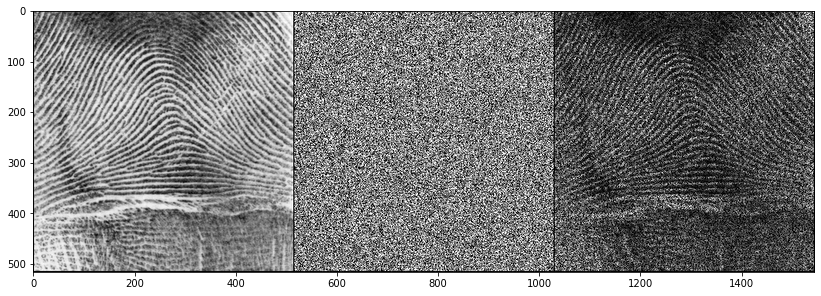

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1         [-1, 32, 514, 514]               0
            Conv2d-2        [-1, 128, 256, 256]          36,992
       BatchNorm2d-3        [-1, 128, 256, 256]             256
         LeakyReLU-4        [-1, 128, 256, 256]               0
   ReflectionPad2d-5        [-1, 128, 258, 258]               0
            Conv2d-6        [-1, 128, 256, 256]         147,584
       BatchNorm2d-7        [-1, 128, 256, 256]             256
         LeakyReLU-8        [-1, 128, 256, 256]               0
   ReflectionPad2d-9        [-1, 128, 258, 258]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
  ReflectionPad2d-13        [-1, 128, 130, 130]               0
           Conv2d-14        [-1, 128, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


0/11001 : 12.515084317987185


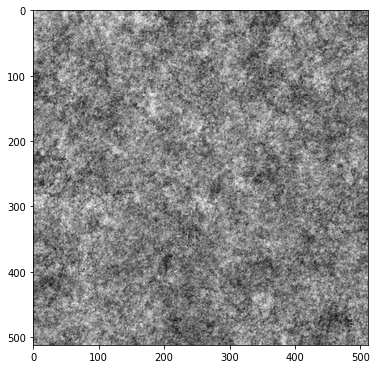

500/11001 : 24.783957681960587


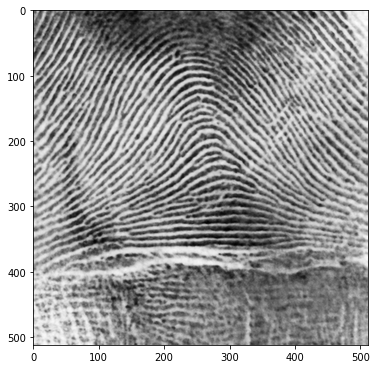

1000/11001 : 26.6535944053779


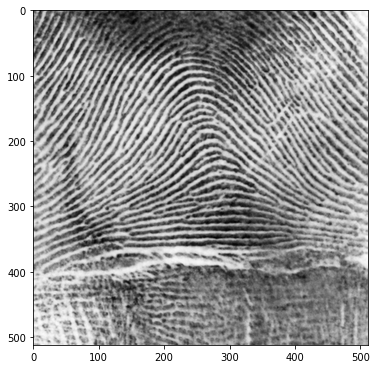

1500/11001 : 27.818584060717416


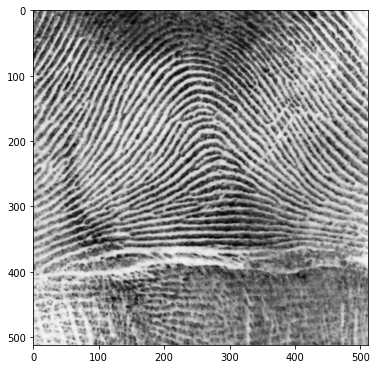

2000/11001 : 28.52186396357559


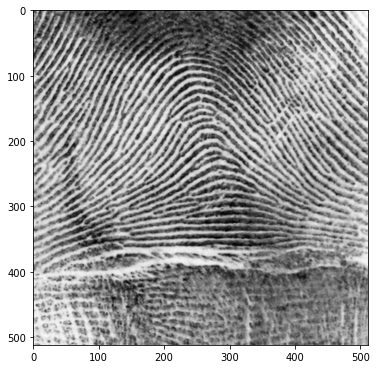

2500/11001 : 29.071419173587323


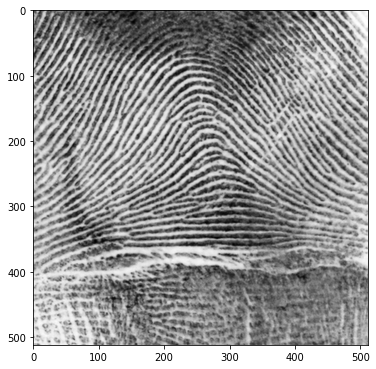

3000/11001 : 29.476152202736007


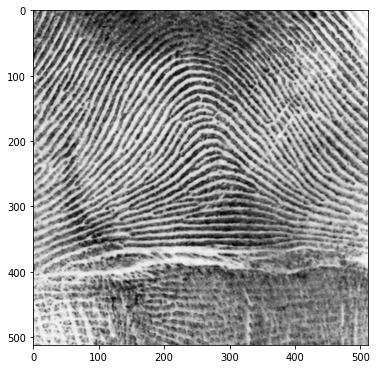

3500/11001 : 30.043678230270594


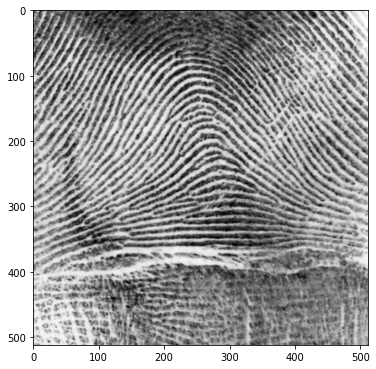

4000/11001 : 30.438746564269454


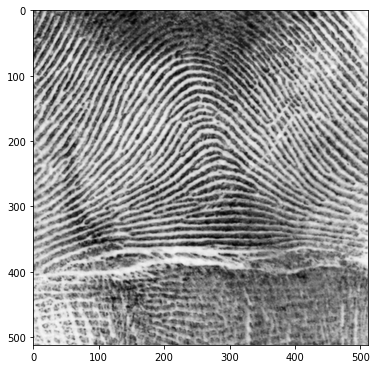

4500/11001 : 30.758473763106906


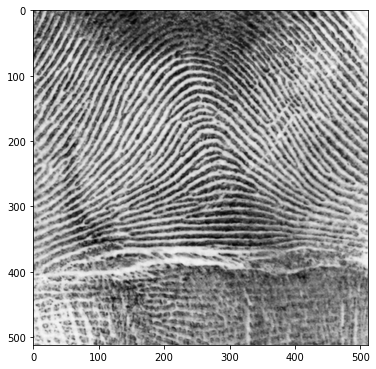

5000/11001 : 31.127723727425018


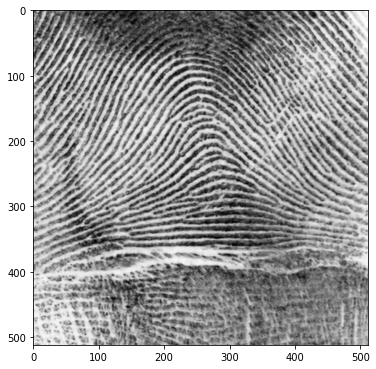

5500/11001 : 31.415014606423483


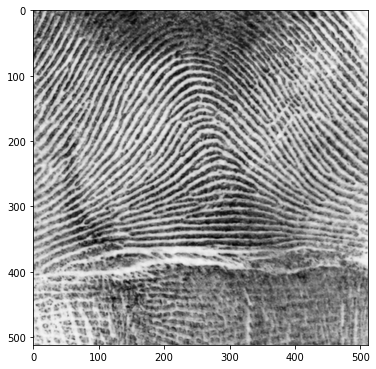

6000/11001 : 31.660371445959825


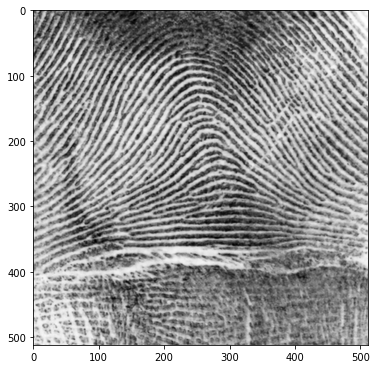

6500/11001 : 31.856380813898312


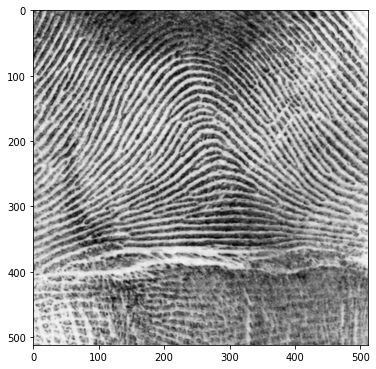

7000/11001 : 32.06061908808528


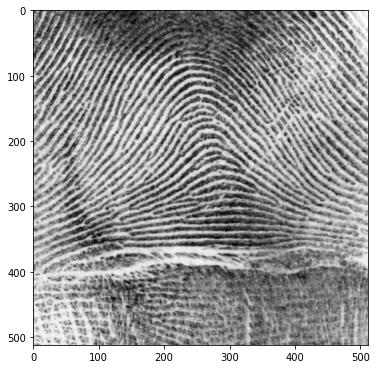

7500/11001 : 32.27237572385371


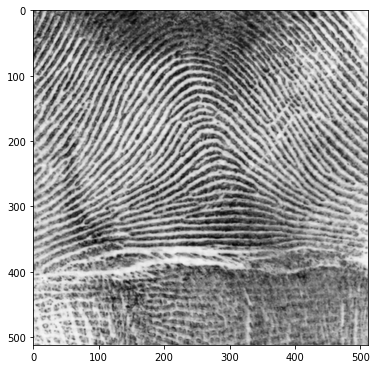

8000/11001 : 32.463458126086536


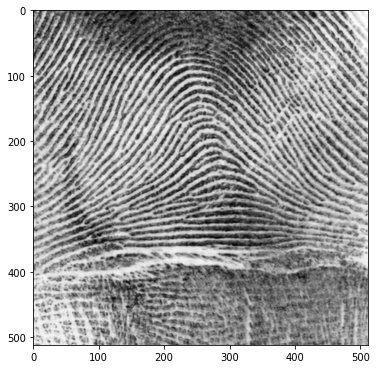

8500/11001 : 32.6210086448556


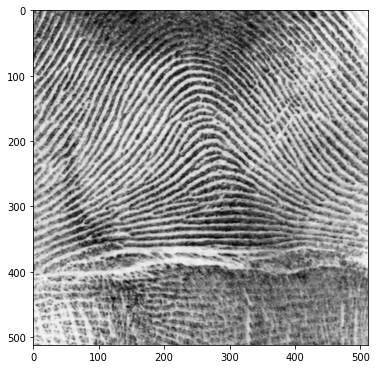

9000/11001 : 32.73401123114829


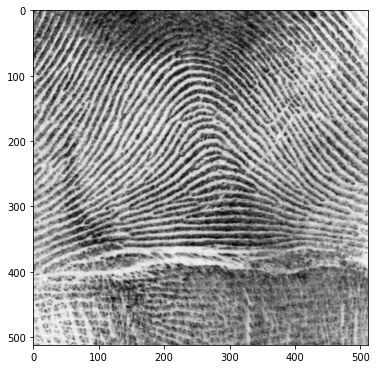

9500/11001 : 32.82961438273139


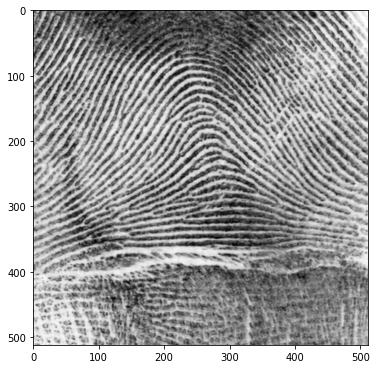

10000/11001 : 32.95821251052262


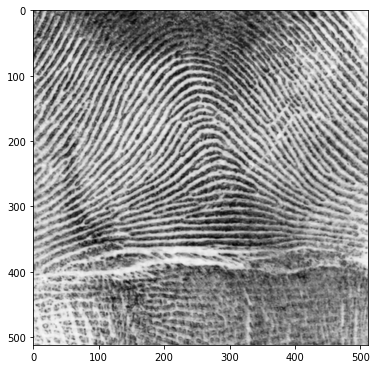

10500/11001 : 32.990716775495066


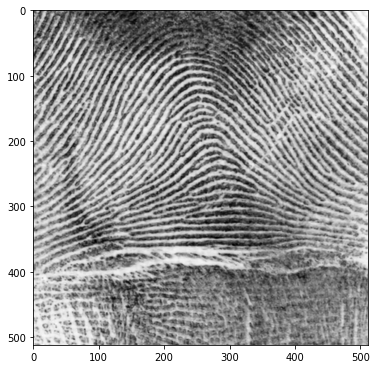

11000/11001 : 32.907226557137705


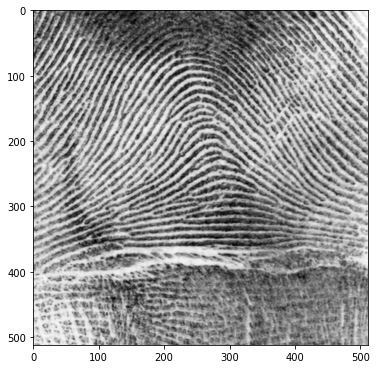

33.11589192091417
10985
psrns
[12.515084317987185, 11.978289487296628, 10.387943151546237, 14.122869445476686, 14.449882935699584, 14.58617632588328, 14.992828908521567, 15.136966133301026, 15.168007679158631, 15.14388462856836, 15.240853828137727, 15.285458883162162, 15.356045950613993, 15.354539292023386, 15.364095818877335, 15.38291755565175, 15.406853354201665, 15.466191534843572, 15.456458840457207, 15.436289697976576, 15.490203307697424, 15.538278499287836, 15.564432242917531, 15.57278052314878, 15.545921563232143, 15.588882413632879, 15.596319315508339, 15.61653855569153, 15.642378001887975, 15.65305802637579, 15.649791795811787, 15.692990385465862, 15.704564476856719, 15.70821285615509, 15.74044320151941, 15.716762203172888, 15.75476363281173, 15.763713629142773, 15.774900288411919, 15.796595343855138, 15.822515570083622, 15.82788345525918, 15.822521860156442, 15.867033564769873, 15.870125697128936, 15.88694603243042, 15.887749749463246, 15.922577585135961, 15.94179169874588, 1

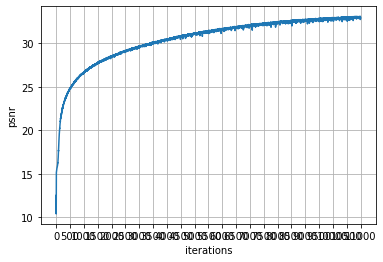

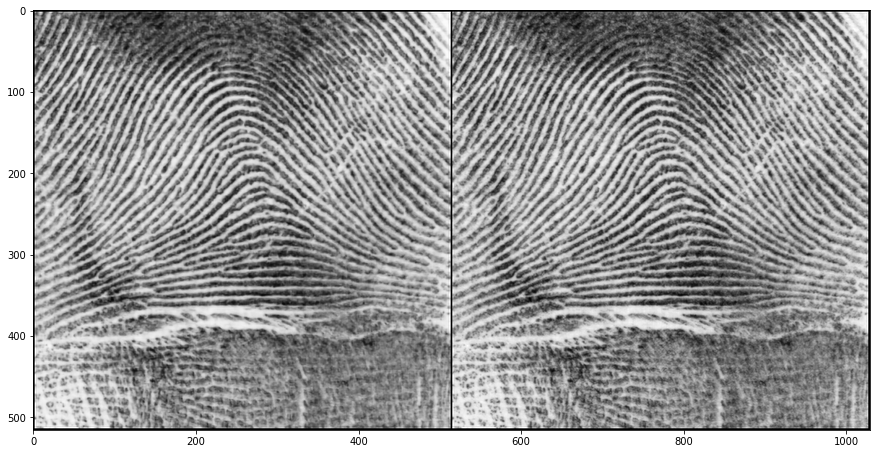

In [11]:
runSkipTest(scenario='identity_skip')

### No Skip connections
In this network structure there are no skip connections. Making it very similar to a UNet, but then using the exact configuration for the down and up layers as in the original network.


In [0]:
runSkipTest(scenario='no_skip')

### Unet
For try-test purposes it is also possible to run the restoration using the UNet network provided by the authors. This network is used in the article to compare results if only a 2% of the pixels remain. Here we test with 50% remaining pixels.

In [0]:
runSkipTest(scenario='unet')

## Reproducing Table 1 - Figure 7 (bottom)

The [Deep Image Prior paper](https://arxiv.org/abs/1711.10925) compares its method of restoring images corrupted with a 50% noise mask with an approach using convolutional sparse coding [1]. The results are presented in table 1 of the Deep Image Prior article.  The claim made by the authors is that the deep image prior performs better than the approach of [1]. In this section we will try to reproduce the deep-image-prior results. 

Table 1 in the [Deep Image Prior paper](https://arxiv.org/abs/1711.10925) displays PSNR (Peak Signal to Noise Ratio) values. The question which comes up is how these PSNR values are determined. This because the Deep Image Prior approach means that during training of the neural network different PSNR values are obtained and PSNR values can vary up and down during the iterations. 

In addition the code in the paper includes a fall back step. If the network deviates too strongly in the wrong direction it will fall back to a previous point and restart the training from there. 

To get a feel for both the development of the PSNR and the fallback consequences we keep track and then plot the PSNR values for each iteration.

The code below is mostly copied from the original [restoration](https://github.com/DmitryUlyanov/deep-image-prior/blob/master/restoration.ipynb) ipynb, with extra code added to load the images, place all in one cell in this notebook and plot the PSNR values.

To run the code, uncomment the line with the image you want to try, and run the cells in this section one by one, with the last cell being the call to the reproduce method.

[1] V. Papyan, Y. Romano, J. Sulam, and M. Elad. Convolutional dictionary learning via local processing. In Proc.
ICCV, 2017.




In [0]:
# uncomment the image you want to test. Note this code assumes that the images are located in the 
# data/restoration folder inside your google drive.
#f = './data/restoration/barbara.png'
f = './data/restoration/man.png'
#f = './data/restoration/montage.png'
#f = './data/restoration/hill.png'
#f = './data/restoration/boat.png'
#f = './data/restoration/house.png'
#f = './data/restoration/Lena512.png'
#f = './data/restoration/Cameraman256.png'
#f = './data/restoration/peppers256.png'
#f = './data/restoration/fingerprint.png'
#f = './data/restoration/couple.png'

In [0]:
# reproducing table 1
from __future__ import print_function
import os
import numpy as np
import torch
import torch.optim
import matplotlib.pyplot as plt
%matplotlib inline
from utils.inpainting_utils import *

# Init
psrns = []
psrns_masked = []
max_psrn = 0
max_iter = 0

last_net = None
psrn_masked_last = 0
i = 0

def reproduce():

  #os.environ['CUDA_VISIBLE_DEVICES'] = '1'

  from models.resnet import ResNet
  from models.unet import UNet
  from models.skip import skip
  from models import get_net
  from skimage.measure import compare_psnr

  torch.backends.cudnn.enabled = True
  torch.backends.cudnn.benchmark =True
  dtype = torch.cuda.FloatTensor

  PLOT = True
  imsize=-1
  dim_div_by = 64
  dtype = torch.cuda.FloatTensor

  img_pil, img_np = get_image(f, imsize)

  img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
  img_pil = np_to_pil(img_np)
  
  img_mask = get_bernoulli_mask(img_pil, 0.50)
  img_mask_np = pil_to_np(img_mask)

  img_masked = img_np * img_mask_np

  mask_var = np_to_torch(img_mask_np).type(dtype)

  plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);

  show_every=500
  figsize=5
  pad = 'reflection' # 'zero'
  INPUT = 'noise'
  input_depth = 32
  OPTIMIZER = 'adam'
  OPT_OVER =  'net'
  
  LR = 0.001
  num_iter = 11001
  reg_noise_std = 0.03
  
  NET_TYPE = 'skip'
  net = get_net(input_depth, 'skip', pad, n_channels=1,
                skip_n33d=128, 
                skip_n33u=128, 
                skip_n11=4, 
                num_scales=5,
                upsample_mode='bilinear').type(dtype)
      
  # Loss
  mse = torch.nn.MSELoss().type(dtype)
  img_var = np_to_torch(img_np).type(dtype)

  net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()

  def closure():

    global i, psrn_masked_last, last_net, net_input, max_psrn, max_iter, psrns, psrns_masked
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    
    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask_np) 
    psrn = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 

    psrns.append(psrn)
    psrns_masked.append(psrn_masked)
    if psrn > max_psrn:
      max_psrn = psrn
      max_iter = i
    print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
    
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        
        # Backtracking
        if psrn_masked - psrn_masked_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked


        print(str(i) + "/" + str(num_iter) + " : " + str(psrn))

        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  # Run
  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

  print(max_psrn)
  print(max_iter)
  out_np = torch_to_np(net(net_input))
  q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

  plt.plot(psrns)
  plt.xticks(range(0, 11001, 500))
  plt.ylabel('psnr')
  plt.xlabel('iterations')
  plt.grid()
  plt.show()


In [0]:
reproduce()

## Super Resolution


### Reproduction

Another application of deep image priors discussed in the paper is super resolution. The aim of this task is to create a high resolution image from a low resolution image by upsampling it with a factor $t$. In other words, when having a low resolution image $x_0 \in ℝ^{3 \times H \times W}$, you generate the high resolution image $x \in ℝ^{3 \times tH \times tW}$. To solve this problem the data term is set to $E(x;x_0) = ||d(x) - x_0||^2$, where $d(\cdot) : ℝ^{3 \times tH \times tW} \to ℝ^{3 \times H \times W}$ is a downsampling operator that resizes the high resolution image to a low resolution image by a factor $t$. The goal is to minimize $E$ and therefore to find a high resolution image, when downsampling is the same as the original low resolution image. 

The paper evaluated two datasets and showed the results in the supplementary material. We will reproduce one dataset since we have limited time and the differences in images between the datasets are not very significant in our opinion. It would be more interesting to adjust the code to get better results. The code for reproduction is given below and to run the code, uncomment the line of the image you want to try and the factor of how much you want to upscale the image.


In [0]:
# path_to_image = 'SR_images/Set5/baby.png'
path_to_image = 'SR_images/Set5/bird.png'
# path_to_image = 'SR_images/Set5/butterfly.png'
# path_to_image = 'SR_images/Set5/head.png'
# path_to_image = 'SR_images/Set5/woman.png'

factor = 4
# factor = 8 

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import argparse
import os
import numpy as np
from models import *
import torch
import torch.optim
from skimage.measure import compare_psnr
from models.downsampler import Downsampler
from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

In [0]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)


input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'


net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)


def closure():
    global i, net_input, psnr_best_HR, best_image, best_iteration
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if psnr_HR > psnr_best_HR:
        psnr_best_HR = psnr_HR
        best_image = out_HR
        best_iteration = i

    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=2)

        print(str(i) + "/" + str(num_iter) + " : " + str(psnr_LR) + ", " + str(psnr_HR))


    i += 1
    
    return total_loss


psnr_best_HR = 0
best_image = 0
best_iteration = 0
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)


out_HR_np = np.clip(torch_to_np(best_image), 0, 1)

plot_image_grid([imgs['HR_np'], out_HR_np], factor=13, nrow=2);

print(str(best_iteration) + " : " + str(psnr_best_HR))

The result we got when running all examples are shown in the tables below and compared with the results of Ulyanov et al.


| | Baby | Bird | Butterfly | Head | Woman |
|-|-|-|-|-|-|
| Ulyanov et al. | 31.49 | 31.8 | 26.23 | 31.04 | 28.93 |
| Ours LR | 34.36529932402503 | 35.54445532546047 | 37.85091199603584 | 36.5863388389097 | 36.04726591794942 |
| Ours HR | 29.533271086683413 | 28.864289695199304 | 24.408632002667886 | 28.205251617471486 | 26.773180053041045 |

<div align="center">Super-resoution PSNR comparison on Set5 dataset with factor 4x.</div>

| | Baby | Bird | Butterfly | Head | Woman |
|-|-|-|-|-|-|
| Ulyanov et al. | 28.28 | 27.09 | 20.02 | 29.55 | 24.5 |
| Ours LR | 38.900908415152195 | 42.4809241492805 | 42.57606031771982 | 40.95015574831018 | 41.78949489818053 |
| Ours HR | 26.954017559788728 | 24.790998174772056 | 18.9492846241358 | 27.07757116122853 | 23.14967179820611 |

<div align="center">Super-resoution PSNR comparison on Set5 dataset with factor 8x.</div>


### Hyperparameter Analysis

The following code makes it possible to run super resolution with customized parameters and plot graphs.

In [0]:
def superResolution(img_path, label, LR = 0.01, factor = 4, num_iter = 2000, reg_noise_std = 0.03):

    global i, net_input, psnr_best_HR, best_image, best_iteration


    # Starts here
    imgs = load_LR_HR_imgs_sr(img_path , imsize, factor, enforse_div32)
    plot_image_grid([imgs['HR_np']], factor = 6)
    plot_image_grid([imgs['LR_np']], factor = 6)


    input_depth = 32
 
    INPUT =     'noise'
    pad   =     'reflection'
    OPT_OVER =  'net'
    KERNEL_TYPE='lanczos2'

    tv_weight = 0.0

    OPTIMIZER = 'adam'

    net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

    NET_TYPE = 'skip' # UNet, ResNet
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    # Losses
    mse = torch.nn.MSELoss().type(dtype)

    img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

    downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)


    def closure():
        global i, net_input, psnr_best_HR, best_image, best_iteration
    
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out_HR = net(net_input)
        out_LR = downsampler(out_HR)

        total_loss = mse(out_LR, img_LR_var) 
    
        if tv_weight > 0:
            total_loss += tv_weight * tv_loss(out_HR)
        
        total_loss.backward()

        # Log
        psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
        psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
                      
        # History
        psnr_history.append(psnr_HR)
    
        if psnr_HR > psnr_best_HR:
            psnr_best_HR = psnr_HR
            best_image = out_HR
            best_iteration = i

        if PLOT and i % 100 == 0:
            out_HR_np = torch_to_np(out_HR)
            plot_image_grid([imgs['HR_np'], np.clip(out_HR_np, 0, 1)], factor=12, nrow=2)

            print(str(i) + "/" + str(num_iter) + " : " + str(psnr_LR) + ", " + str(psnr_HR))

            plt.plot(psnr_history, label = label)
            plt.xticks(range(0, num_iter + 1, 500))
            plt.ylabel('psnr')
            plt.xlabel('iterations')
            plt.grid()
            plt.legend()
            plt.show()


        i += 1
    
        return total_loss


    psnr_best_HR = 0
    best_image = 0
    best_iteration = 0
    psnr_history = [] 
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    i = 0
    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)


    out_HR_np = np.clip(torch_to_np(best_image), 0, 1)

    plot_image_grid([imgs['HR_np'], out_HR_np], factor=12, nrow=2);
    plot_image_grid([imgs['LR_np']], factor = 6)

    print(str(best_iteration) + " : " + str(psnr_best_HR))

    plt.plot(psnr_history, label = label)
    plt.xticks(range(0, num_iter + 1, 500))
    plt.ylabel('psnr')
    plt.xlabel('iterations')
    plt.grid()
    plt.legend()
    plt.show()

    return psnr_history, label
    

#### Learning rate
We first test different learning rates.

In [0]:
data1, label1 = superResolution(path_to_image, "0.1", LR= 0.1, factor = 4, reg_noise_std = 0.03, num_iter = 2000)
data2, label2 = superResolution(path_to_image, "0.01", LR= 0.01, factor = 4, reg_noise_std = 0.03, num_iter = 2000)
data3, label3 = superResolution(path_to_image, "0.001", LR= 0.001, factor = 4, reg_noise_std = 0.03, num_iter = 2000)
data4, label4 = superResolution(path_to_image, "0.0001", LR= 0.0001, factor = 4, reg_noise_std = 0.03, num_iter = 2000)


plt.plot(data1, label = label1)
plt.plot(data2, label = label2)
plt.plot(data3, label = label3)
plt.plot(data4, label = label4)
plt.xticks(range(0, 2001, 500))
plt.ylabel('psnr')
plt.xlabel('iterations')
plt.grid()
plt.legend()
plt.show()

---

## Conclusions
From the experiments run above we can conclude that indeed the results from the original Deep Image Prior paper can be replicated with their code and that the results are very dependend on the choice of hyperparameters. Hyperparameter tweaking is needed when trying this method on a different set of images.

Another important conclusion is that indeed these convolutional networks have a strong tendency to prefer natural structures. This behavior seems even stronger than indicated. The sudden drops in the PSNR values are specific and it not sure why this happens.

The claim in table 1 of the original article that the Deep Image Prior performs better than the indicated alternative solution are not reproducable. Especially because the variations in the PSNR are considerable and larger than the published improvement in table 1.